<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Regression Tutorial SWDB 2018 </h1> 
<h3 align="center">Friday, August 24, 2018</h3> 

In [316]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LinearRegression as LR

Discuss loss functions and performance; definition of ML problem

Example problem type:  Regression

Examples of regression problems; definition of linear regression; solution (can be calculated exactly)

First example:  polynomial regression, start with y = mx + b, add orders of polynomials

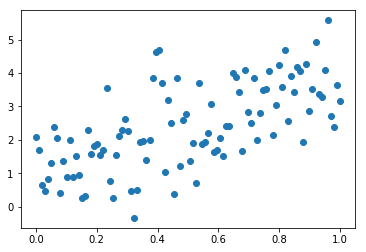

In [6]:
x = np.linspace(0,1.0, 100)

m_true = 3.0
b_true = 1.0

y = m_true*x + b_true + np.random.normal(size=100)

plt.plot(x, y, 'o')

In [9]:
b_hat = np.mean(y)
m_hat = np.cov(x,y)[0,1]/np.var(x)

2.8069951802407638 2.4088968915328053


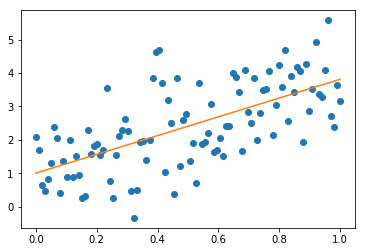

In [12]:
plt.plot(x,y,'o')
plt.plot(x, m_hat*(x-np.mean(x)) + b_hat)

print m_hat, b_hat

definition of supervised learning
simple regression
need for train/validate/test
exact solution for harder problem?
sklearn interface (cross validation; model selection)

running data from BOb

In [1]:
MANIFEST_FILE = '/Volumes/Brain2018/visual_coding_2p/manifest.json'

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [4]:
boc = BrainObservatoryCache(manifest_file=MANIFEST_FILE)

In [6]:
exp_cont = boc.get_experiment_containers(ids=[571684731])

In [185]:
#eid = boc.get_ophys_experiments(session_types=['three_session_A'], experiment_container_ids=[571684731])[0]['id']
eid = boc.get_ophys_experiments(session_types=['three_session_A'], experiment_container_ids=[564425775])[0]['id']

In [186]:
data = boc.get_ophys_experiment_data(eid)

In [361]:
# data.get_cell_specimen_indices([572611384])
cell = data.get_cell_specimen_indices([570927732])[0]
print(cell)

142


In [315]:
dx, time = data.get_running_speed()

L = dx.shape[0]

dx_train = dx[:L/2]
dx_validate = dx[L/2:3*L/4]
dx_test = dx[3*L/4:]

time, dff = data.get_dff_traces()

dff_train = dff[:,:L/2]
dff_validate = dff[:,L/2:3*L/4]
dff_test = dff[:,3*L/4:]

print((L, dff.shape[1]))

(115721, 115721)


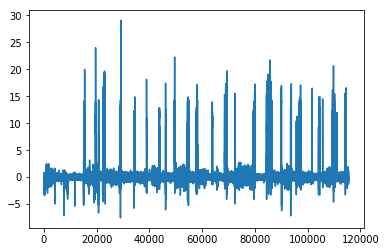

In [190]:
plt.plot(dx)

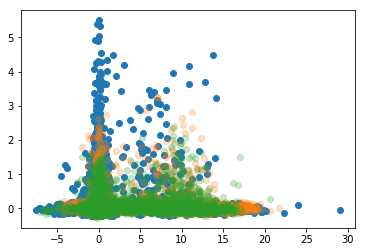

In [362]:
plt.plot(dx_train, dff_train[cell],'o')
plt.plot(dx_validate, dff_validate[cell],'o',alpha=0.25)
plt.plot(dx_test, dff_test[cell],'o',alpha=0.25)

In [238]:
def downsample(a, bin_edges, alt_array=None):
    n = len(bin_edges)-1
    a_downsampled = np.zeros(n)
    if alt_array is not None:
        alt_downsampled_list = [np.zeros(n) for t in alt_array]
    for i in range(n):
        lower = bin_edges[i]
        upper = bin_edges[i+1]
        bin_mask = np.logical_and(a >= lower, a < upper)
        a_downsampled[i] = np.mean(a[bin_mask])
        if alt_array is not None:
            for j in range(len(alt_array)):
                alt_downsampled_list[j][i] = np.mean(alt_array[j][bin_mask])
            # alt_downsampled[i] = [np.mean(alt_array[bin_mask])
        
    if alt_array is not None:
        return a_downsampled, alt_downsampled_list
    else:
        return a_downsampled

In [393]:
bin_edges = np.linspace(0,18,100)

running_ds_train, dff_ds_train = downsample(dx_train, bin_edges, [dff_train[142]])
running_ds_validate, dff_ds_validate = downsample(dx_validate, bin_edges, [dff_validate[142]])
running_ds_test, dff_ds_test = downsample(dx_test, bin_edges, [dff_test[142]])

dff_ds_train = dff_ds_train[0]
dff_ds_validate = dff_ds_validate[0]
dff_ds_test = dff_ds_test[0]

/Users/michaelbu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/Users/michaelbu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [312]:
def remove_negative(running, dff):
    pos_mask = running >= 0
    running = running[pos_mask]
    dff = dff[pos_mask]
    
    return running, dff
     
running_ds_train, dff_ds_train = remove_negative(running_ds_train, dff_ds_train)
running_ds_validate, dff_ds_validate = remove_negative(running_ds_validate, dff_ds_validate)
running_ds_test, dff_ds_test = remove_negative(running_ds_test, dff_ds_test)


# pos_mask = running_ds_train >= 0
# running_ds_train = running_ds_train[pos_mask]
# diff_ds_train = diff_ds_train[pos_mask]

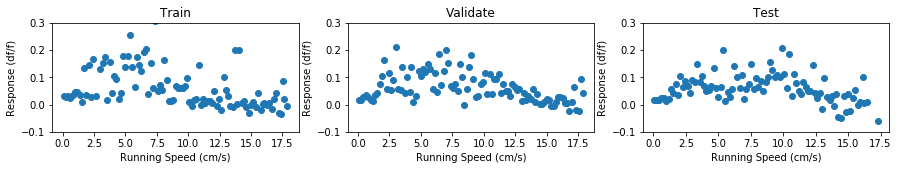

In [394]:
fig, ax = plt.subplots(1,3, figsize=(15,2))
ax[0].plot(running_ds_train, dff_ds_train, 'o')
ax[1].plot(running_ds_validate, dff_ds_validate, 'o')
ax[2].plot(running_ds_test, dff_ds_test, 'o')

ax[0].set_title('Train')
ax[1].set_title('Validate')
ax[2].set_title('Test')

for i in range(3):
    ax[i].set_ylim(-0.1, 0.3)
    ax[i].set_xlabel('Running Speed (cm/s)')
    ax[i].set_ylabel('Response (df/f)')

In [370]:
lr_order1 = LR()
lr_order1.fit(running_ds_train.reshape(-1,1), dff_ds_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [371]:
lr_order1.intercept_, lr_order1.coef_

(0.12147399342271491, array([-0.00625794]))

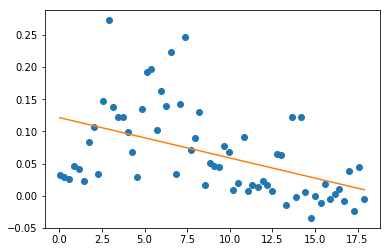

In [375]:
x = np.linspace(0,18,200)

fig, ax = plt.subplots()
ax.plot(running_ds_train, dff_ds_train, 'o')
ax.plot(running_ds_train.reshape(-1,1), lr_order1.predict(running_ds_train.reshape(-1,1)))

In [378]:
nth_polynomial = lambda x, n:  np.stack([x**i for i in range(1, n+1)], axis=1)

In [379]:
polynomial_curve = lambda coef, intercept:  (np.sum([c*(x**(i+1)) for i, c in enumerate(coef)], axis=0) + intercept )

In [380]:
max_order = 9

lr_list = [LR() for i in range(max_order)]
for i, lr in enumerate(lr_list):
    running_nth_order = nth_polynomial(running_ds_train, i+1)
    lr.fit(running_nth_order, dff_ds_train)

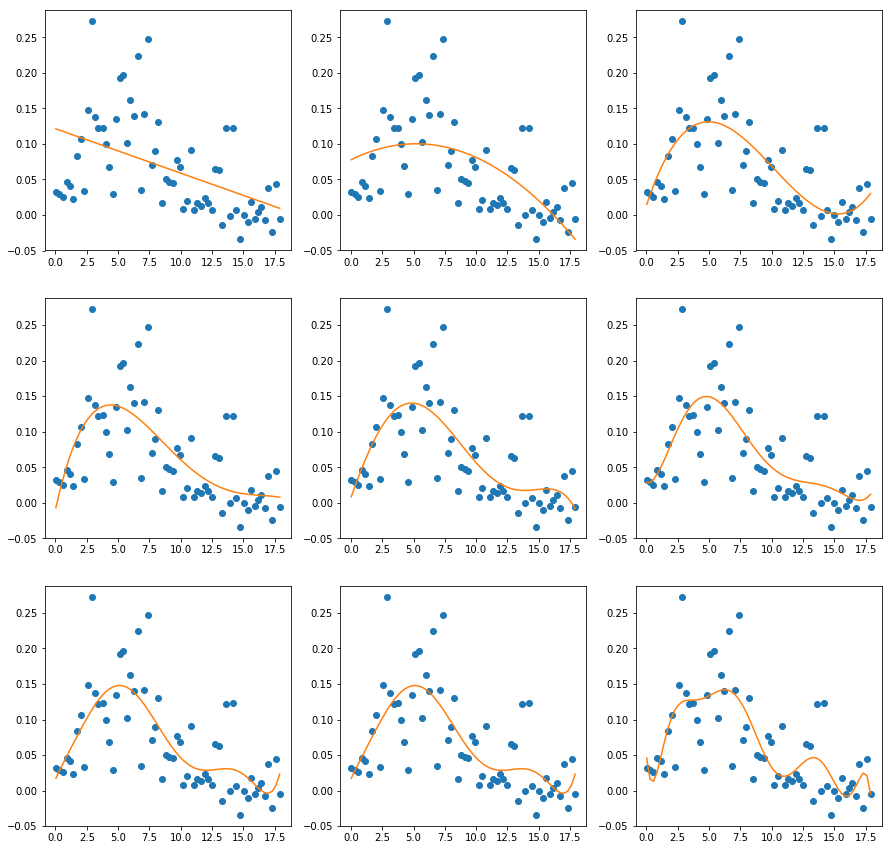

In [382]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

for i, lr in enumerate(lr_list):
    xi = i%3
    yi = i/3
    running_nth_order = nth_polynomial(running_ds_train, i+1)
    ax[yi, xi].plot(running_ds_train, dff_ds_train, 'o')
    ax[yi, xi].plot(running_ds_train, lr.predict(running_nth_order))

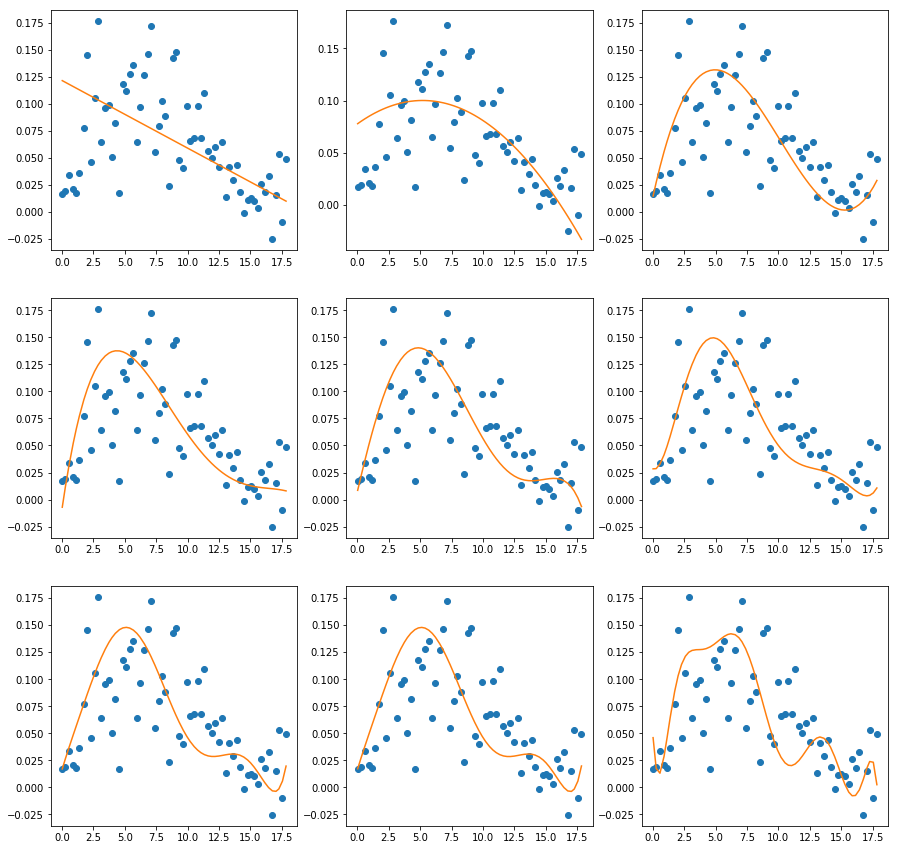

In [384]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

for i, lr in enumerate(lr_list):
    xi = i%3
    yi = i/3
    ax[yi, xi].plot(running_ds_validate, dff_ds_validate, 'o')
    running_nth_order = nth_polynomial(running_ds_validate, i+1)
    ax[yi, xi].plot(running_ds_validate, lr.predict(running_nth_order))

(-0.1, 0.2)

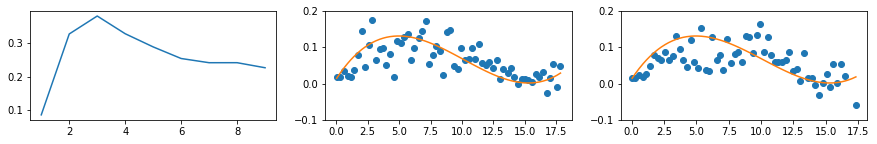

In [388]:
R2_vals = []

for i, lr in enumerate(lr_list):
    running_nth_order = nth_polynomial(running_ds_validate, i+1)
    R2 = lr.score(running_nth_order, dff_ds_validate)
    R2_vals.append(R2)
    
order = np.arange(1,len(R2_vals)+1)
    
fig, ax = plt.subplots(1,3, figsize=(15,2))
ax[0].plot(order, R2_vals)

best_model_index = np.argmax(R2_vals)
lr_best = lr_list[best_model_index]

ax[1].plot(running_ds_validate, dff_ds_validate, 'o')
running_nth_order = nth_polynomial(running_ds_validate, best_model_index+1)
ax[1].plot(running_ds_validate, lr_best.predict(running_nth_order))
ax[1].set_ylim(-0.1, 0.2)

ax[2].plot(running_ds_test, dff_ds_test, 'o')
running_nth_order = nth_polynomial(running_ds_test, best_model_index+1)
ax[2].plot(running_ds_test, lr_best.predict(running_nth_order))
ax[2].set_ylim(-0.1, 0.2)

In [346]:
running_nth_order = nth_polynomial(running_ds_test, best_model_index+1)
print(lr_best.score(running_nth_order, dff_ds_test))

-0.15703148408697953


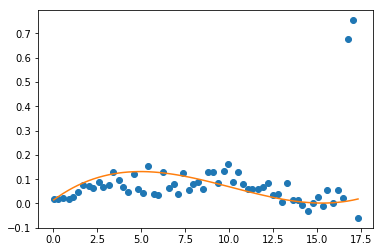

In [391]:
fig, ax = plt.subplots()

ax.plot(running_ds_test, dff_ds_test, 'o')
running_nth_order = nth_polynomial(running_ds_test, best_model_index+1)
ax.plot(running_ds_test, lr_best.predict(running_nth_order))

0.07379250317152775


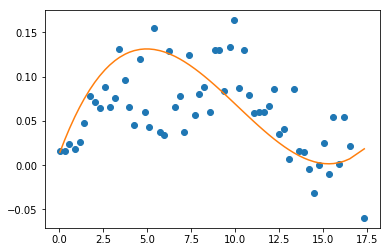

In [392]:
outlier_mask = dff_ds_test < 0.3
running_ds_test_g = running_ds_test[outlier_mask]
dff_ds_test_g = dff_ds_test[outlier_mask]

running_nth_order = nth_polynomial(running_ds_test_g, best_model_index+1)
print(lr_best.score(running_nth_order, dff_ds_test_g))

fig, ax = plt.subplots()

ax.plot(running_ds_test_g, dff_ds_test_g, 'o')
ax.plot(running_ds_test_g, lr_best.predict(running_nth_order))